In [73]:
!pip install pycryptodome

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from Crypto.Cipher import AES
import struct

In [75]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [76]:
# 1) One-hot encode categorical features
# These columns have categorical (discrete) values:
# cp (chest pain), restecg (ECG results), thal (thalassemia), slope (ST slope)
df = pd.get_dummies(df, columns=['cp', 'restecg', 'thal', 'slope'], drop_first=True)

In [77]:
# 2) Convert binary / integer features to proper int type
binary_cols = ['sex', 'fbs', 'exang', 'ca', 'target']
for col in binary_cols:
    df[col] = df[col].astype(int)

In [78]:
# 3) Separate features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']

In [79]:
print("\nAfter preprocessing:")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Columns used for training:\n", X.columns.tolist())


After preprocessing:
Shape of X: (303, 19)
Shape of y: (303,)
Columns used for training:
 ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2', 'thal_1', 'thal_2', 'thal_3', 'slope_1', 'slope_2']


In [80]:
# STAGE 1: RANDOM FOREST MODEL + PREDICTION

# 1) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Train Random Forest model
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # allow full growth
    random_state=42
)
rf.fit(X_train, y_train)

# 3) Predict probabilities (risk scores)
# For each test sample, this gives [P(healthy), P(disease)]
y_proba = rf.predict_proba(X_test)[:, 1]  # we only need P(disease)

print("Sample predicted probabilities (first 10):")  #Each value = model’s confidence that the patient has heart disease (1.0 = 100% sure, 0.0 = 0% sure)
print(y_proba[:10])

Sample predicted probabilities (first 10):
[0.165 0.41  0.015 0.765 0.595 0.115 0.87  0.575 0.86  0.495]


Model Evaluation Results:
Accuracy:  0.770
ROC-AUC:   0.898

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.82      0.64      0.72        28
     Disease       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61

Confusion Matrix:
 [[18 10]
 [ 4 29]]


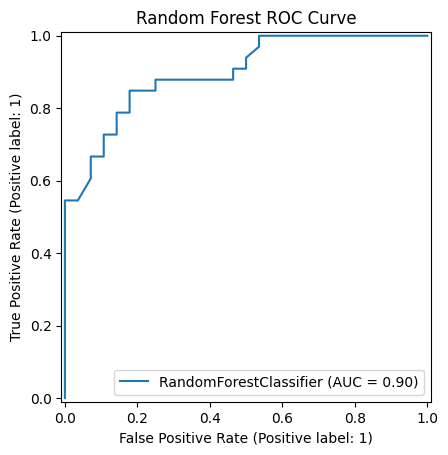

In [81]:
# EVALUATE THE RANDOM FOREST MODEL

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
# Predict class labels (0 or 1)
y_pred = rf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, target_names=["No Disease", "Disease"])

print("Model Evaluation Results:")
print("=========================")
print(f"Accuracy:  {acc:.3f}")
print(f"ROC-AUC:   {roc:.3f}")
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot ROC curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()


In [82]:
# SAVE PREDICTION PROBABILITIES TO CSV
# Combine the test data with model predictions
results_df = X_test.copy()
results_df["Actual_Label"] = y_test.values
results_df["Predicted_Probability"] = y_proba
results_df["Predicted_Label"] = (y_proba >= 0.5).astype(int)

# Save to CSV for AES encryption or report documentation
results_df.to_csv("heart_risk_predictions.csv", index=False)

print("\nSaved predictions to 'heart_risk_predictions.csv'")
print("Sample preview:")
print(results_df.head(10))


Saved predictions to 'heart_risk_predictions.csv'
Sample preview:
     age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  ca   cp_1  ...  \
179   57    1       150   276    0      112      1      0.6   1  False  ...   
197   67    1       125   254    1      163      0      0.2   2  False  ...   
285   46    1       140   311    0      120      1      1.8   2  False  ...   
194   60    1       140   185    0      155      0      3.0   0  False  ...   
188   50    1       140   233    0      163      0      0.6   1  False  ...   
240   70    1       160   269    0      112      1      2.9   1  False  ...   
160   56    1       120   240    0      169      0      0.0   0   True  ...   
167   62    0       140   268    0      160      0      3.6   2  False  ...   
136   60    0       120   178    1       96      0      0.0   0  False  ...   
228   59    1       170   288    0      159      0      0.2   0  False  ...   

     restecg_1  restecg_2  thal_1  thal_2  thal_3  slope_1  slo

In [83]:
# STAGE 2:ENCODE RISK SCORES + AES-128 ENCRYPTION (PYTHON)

# 1) Choose how many samples to use for the project demo
NUM_BLOCKS = 16   # Can increase later if we want
probs = y_proba[:NUM_BLOCKS]   # first N risk scores
print(f"\nUsing {NUM_BLOCKS} risk scores for AES demo:")
print(probs)


Using 16 risk scores for AES demo:
[0.165 0.41  0.015 0.765 0.595 0.115 0.87  0.575 0.86  0.495 0.45  0.855
 0.175 0.825 0.865 0.715]


In [84]:
# 2) Encode each probability into a 16-byte AES block
# Scheme:
#   - p in [0,1]  --> scale: p_scaled = int(round(p * 1_000_000))
#   - store p_scaled as 4 bytes big-endian
#   - pad with zeros to make 16 bytes total
blocks = []

for p in probs:
    p_scaled = int(round(p * 1_000_000))       # e.g. 0.873421 -> 873421
    p_bytes  = struct.pack(">I", p_scaled)     # 4-byte big-endian unsigned int
    block    = p_bytes + b"\x00" * 12          # 4 + 12 = 16 bytes
    blocks.append(block)

print("\nExample plaintext block (hex):")
print(blocks[0].hex())


Example plaintext block (hex):
00028488000000000000000000000000


In [85]:
# 3) AES-128 encryption in ECB mode (software reference)
key_hex   = "00112233445566778899AABBCCDDEEFF"   # 128-bit key
key_bytes = bytes.fromhex(key_hex)

cipher = AES.new(key_bytes, AES.MODE_ECB)

with open("plaintext_risk.hex", "w") as f_plain, \
     open("ciphertext_ref.hex", "w") as f_ref:

    for blk in blocks:
        pt_hex = blk.hex()
        ct_hex = cipher.encrypt(blk).hex()
        f_plain.write(pt_hex + "\n")
        f_ref.write(ct_hex + "\n")

print("\nWrote plaintext_risk.hex and ciphertext_ref.hex")
print("// Use this key in SystemVerilog:")
print("   key = 128'h" + key_hex + ";")


Wrote plaintext_risk.hex and ciphertext_ref.hex
// Use this key in SystemVerilog:
   key = 128'h00112233445566778899AABBCCDDEEFF;


In [86]:
#plaintext_risk.hex

#Each line = 16-byte AES plaintext (1 patient’s risk score encoded).

#ciphertext_ref.hex

#Each line = AES-128 ciphertext from Python (the golden reference).